# **Mobilenet Unet**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Convolution2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Add, Lambda, ReLU, LeakyReLU, concatenate
from tensorflow.keras.applications import MobileNetV2

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-30 06:34:19.313073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 06:34:19.447604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 06:34:19.448739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### **Prepare dataset**

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

### **Load image's path and mask's path**

In [ ]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_1986030

### **Data Visualization**

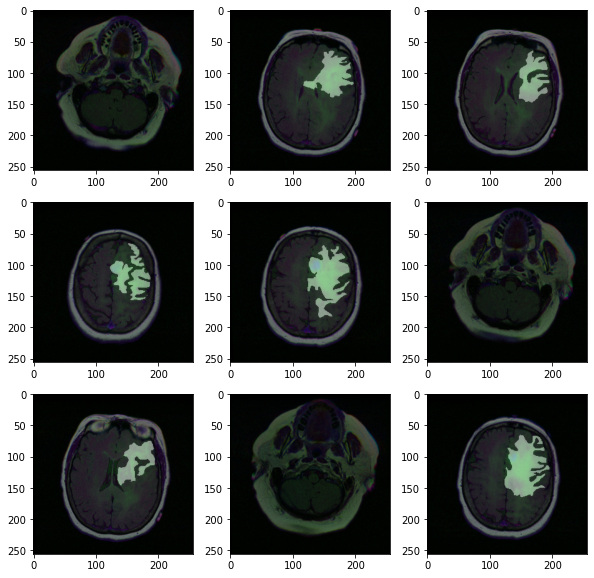

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

### **Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


### **Data genertator, data augmentation and adjust data**

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

## **Model**

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)

    return x

In [ ]:
def build_mobilenetv2_unet(input_shape):
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs, alpha=1.4)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output                ## (512 x 512)
    s2 = encoder.get_layer("block_1_expand_relu").output    ## (256 x 256)
    s3 = encoder.get_layer("block_3_expand_relu").output    ## (128 x 128)
    s4 = encoder.get_layer("block_6_expand_relu").output    ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output   ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                         ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                         ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                         ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                          ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same")(d4)
    outputs = Activation('sigmoid')(outputs)

    model = Model(inputs, outputs, name="MobileNetV2_UNet")
    return model

In [ ]:
mobile_unet = build_mobilenetv2_unet(input_shape=(256,256,3))

2022-06-30 06:34:23.671238: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 06:34:23.671759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 06:34:23.672968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 06:34:23.674010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

17842176/17831080 [==============================] - 1s 0us/step


In [ ]:
mobile_unet.summary()

Model: "MobileNetV2_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 48) 192         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 48) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________

In [ ]:
from tensorflow.keras import backend as K
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 0.001

In [ ]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 0.1)
mobile_unet.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="./Model10_Mobilennetv2Unet_BrainMriSeg.h5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
train_generator_args = dict(rescale=1.0/255.0,
                            rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(rescale=1.0/255.0),
                                target_size=(im_height, im_width))
history = mobile_unet.fit(train_gen,
                  epochs = EPOCHS,
                  steps_per_epoch=len(df_train) / BATCH_SIZE,
                  validation_data = val_gen,
                  validation_steps=len(df_val) / BATCH_SIZE,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2022-06-30 06:34:32.875805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-30 06:34:39.389771: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


177/176 [==============================] - ETA: 0s - loss: 0.9720 - tversky: 0.0372Found 708 validated image filenames.
Found 708 validated image filenames.
176/176 [==============================] - 140s 709ms/step - loss: 0.9720 - tversky: 0.0372 - val_loss: 0.9736 - val_tversky: 0.0354

Epoch 00001: val_loss improved from inf to 0.97357, saving model to ./Model10_Mobilennetv2Unet_BrainMriSeg.h5
Epoch 2/100
176/176 [==============================] - 91s 518ms/step - loss: 0.9641 - tversky: 0.0475 - val_loss: 0.9706 - val_tversky: 0.0400

Epoch 00002: val_loss improved from 0.97357 to 0.97064, saving model to ./Model10_Mobilennetv2Unet_BrainMriSeg.h5
Epoch 3/100
176/176 [==============================] - 90s 511ms/step - loss: 0.9561 - tversky: 0.0580 - val_loss: 0.9655 - val_tversky: 0.0463

Epoch 00003: val_loss improved from 0.97064 to 0.96553, saving model to ./Model10_Mobilennetv2Unet_BrainMriSeg.h5
Epoch 4/100
176/176 [==============================] - 94s 531ms/step - loss: 0.9

## Model Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

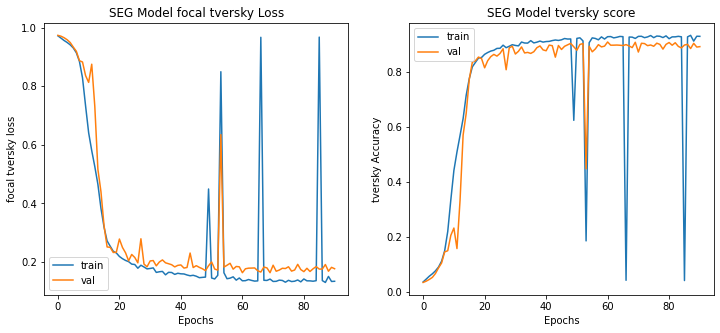

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Segmantation Model Performance

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(rescale=1.0/255.0), target_size=(im_height, im_width))
results = mobile_unet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 7s 300ms/step - loss: 0.1641 - tversky: 0.9070


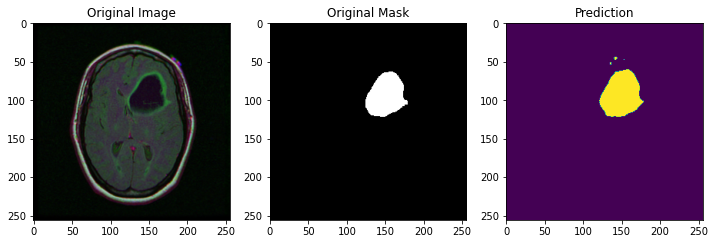

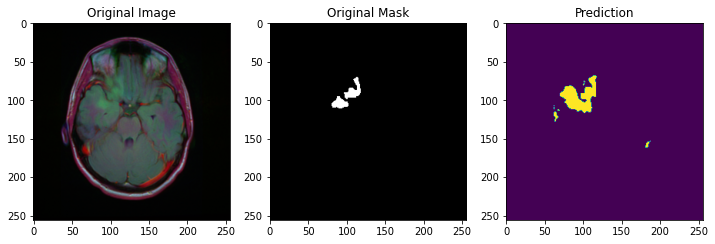

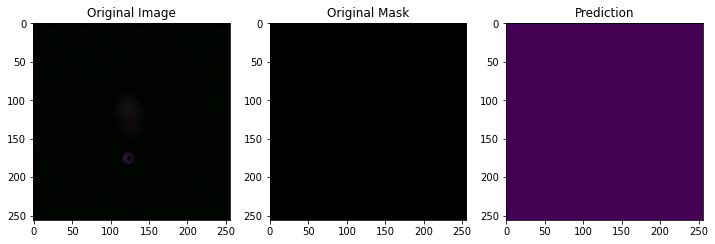

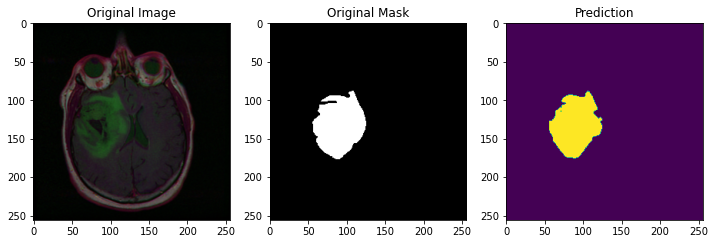

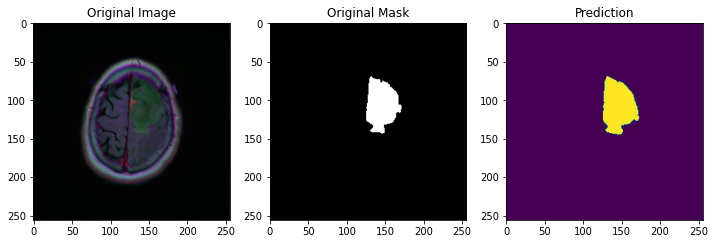

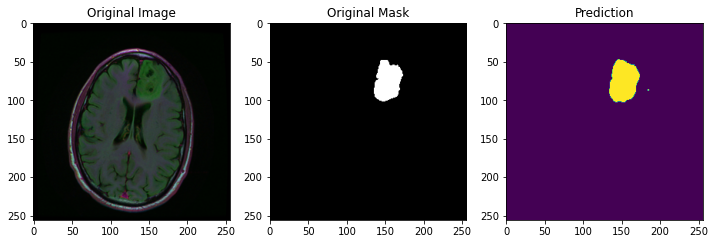

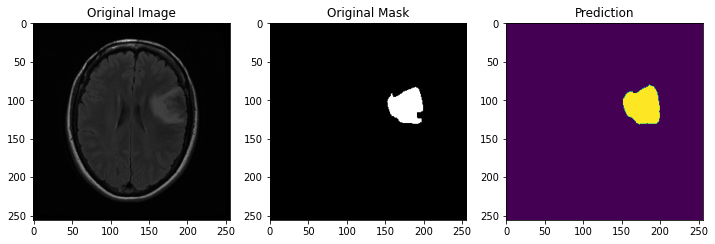

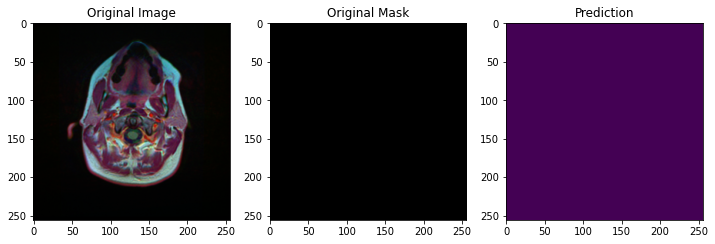

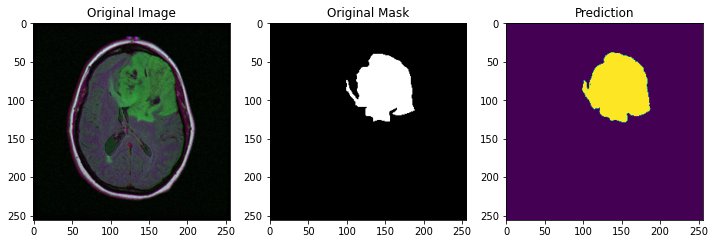

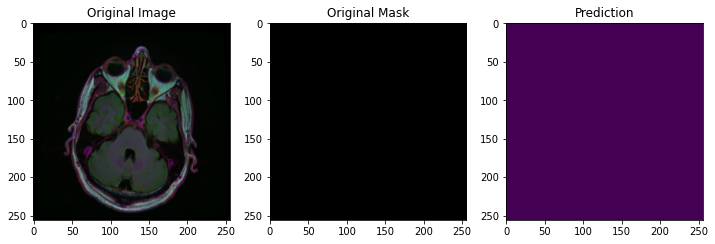

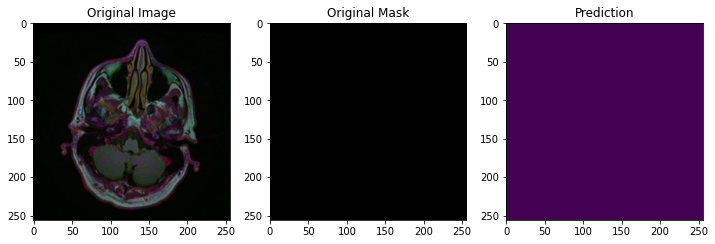

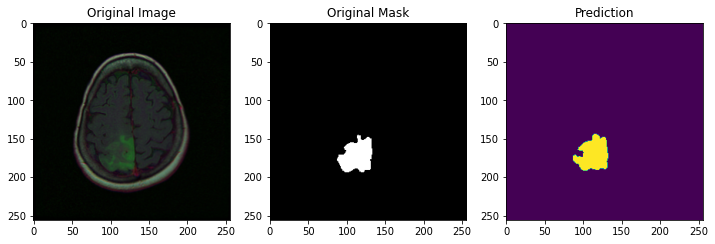

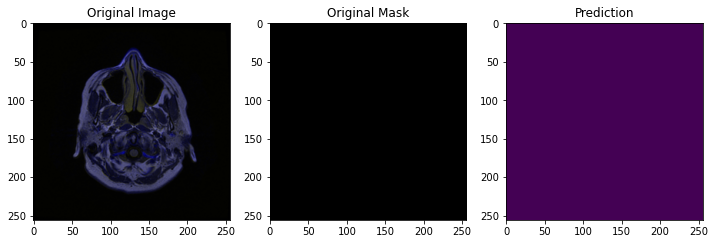

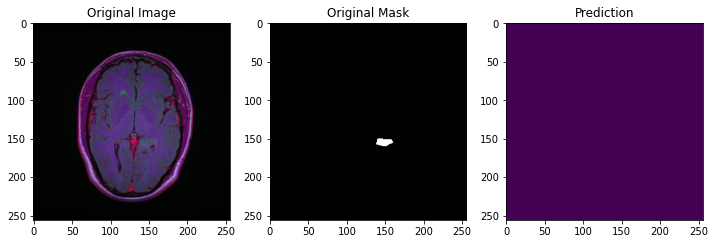

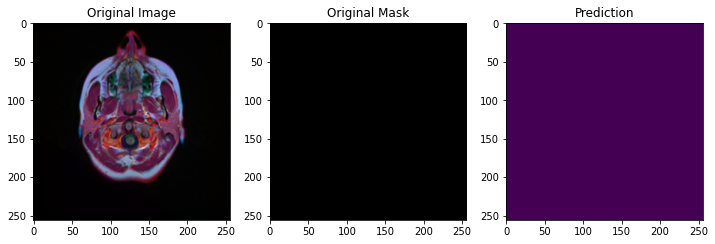

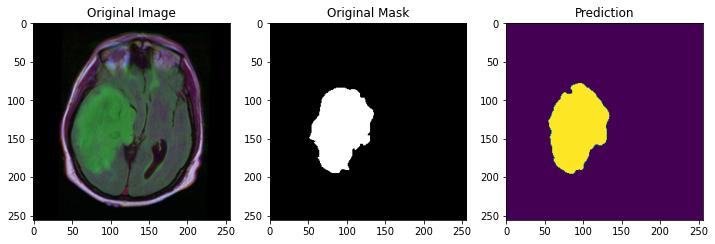

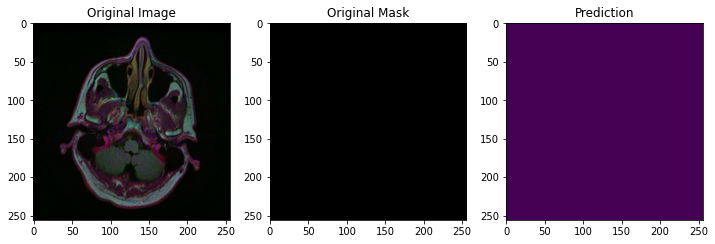

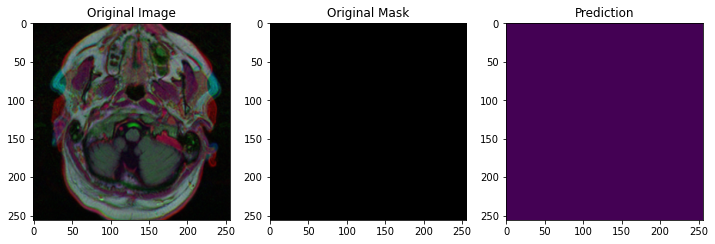

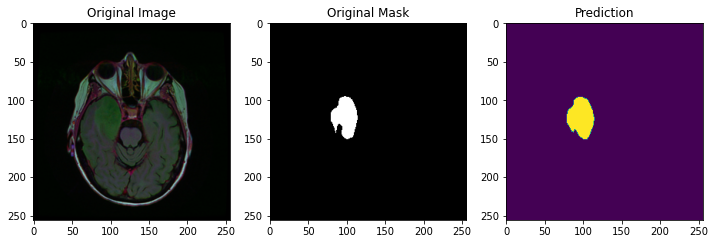

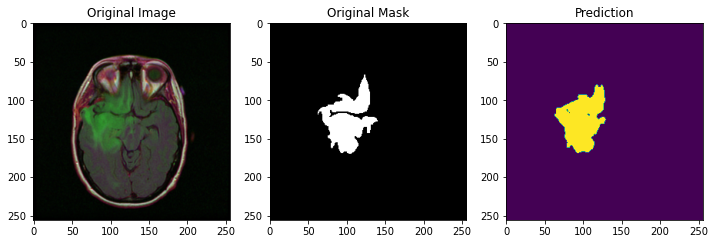

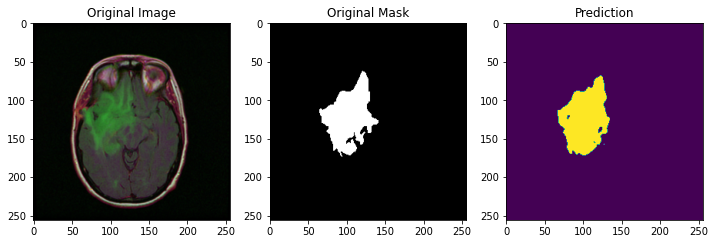

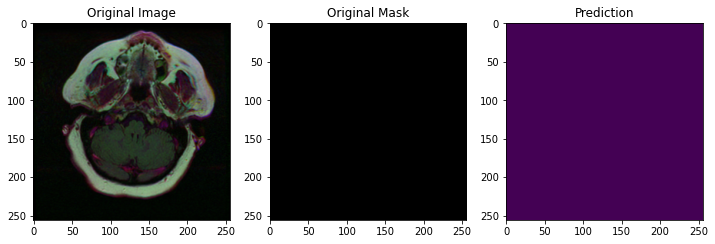

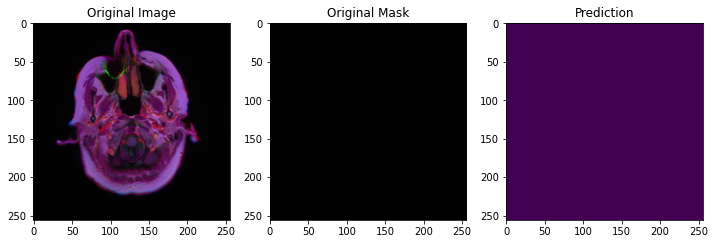

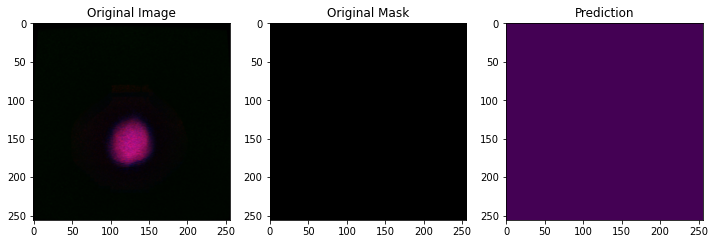

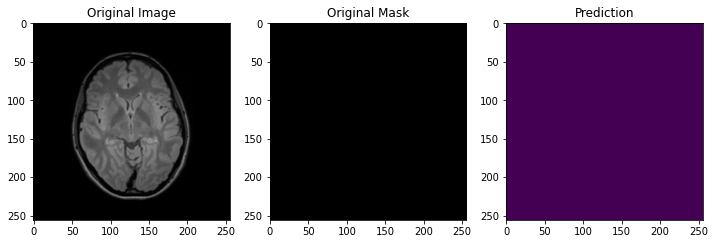

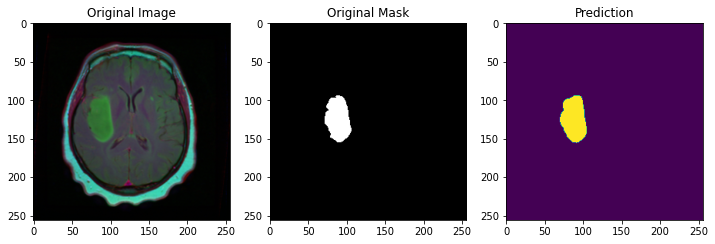

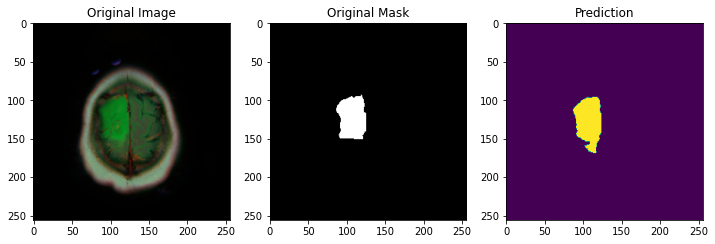

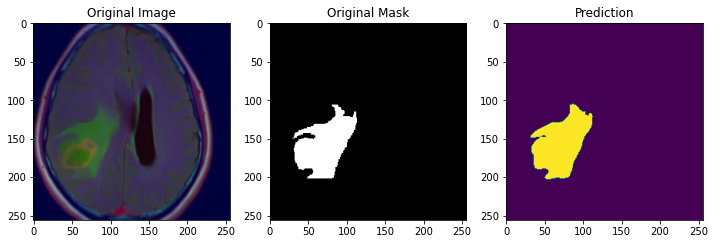

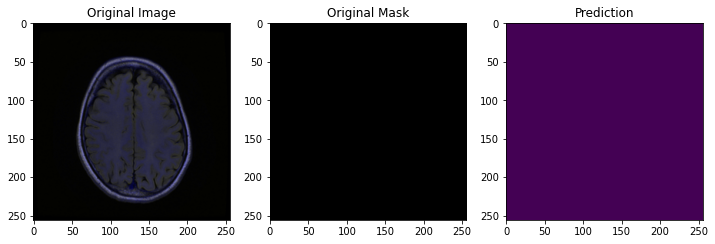

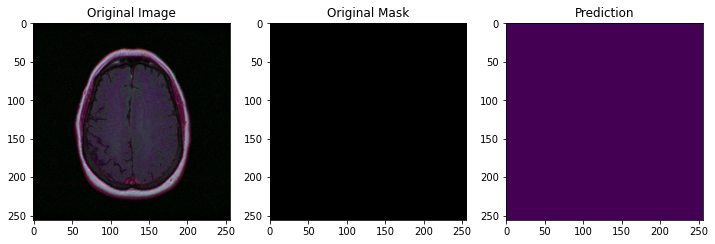

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred= mobile_unet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()